# NAFNet Online Demo on Image Debluring

## Git clone [NAFNet](https://github.com/megvii-research/NAFNet) repo

In [1]:
!git clone https://github.com/megvii-research/NAFNet
%cd NAFNet

Cloning into 'NAFNet'...
remote: Enumerating objects: 521, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 521 (delta 180), reused 142 (delta 142), pack-reused 296 (from 1)
Receiving objects: 100% (521/521), 16.19 MiB | 17.39 MiB/s, done.
Resolving deltas: 100% (277/277), done.
/content/NAFNet


## Set up the enviroment

In [2]:
!pip install -r requirements.txt
!pip install --upgrade --no-cache-dir gdown
!python3 setup.py develop --no_cuda_ext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 11.5 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

       

## Download pretrained models

In [3]:
import gdown
gdown.download('https://drive.google.com/uc?id=14D4V4raNYIOhETfcuuLI3bGLB-OYIv6X', "./experiments/pretrained_models/", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14D4V4raNYIOhETfcuuLI3bGLB-OYIv6X
From (redirected): https://drive.google.com/uc?id=14D4V4raNYIOhETfcuuLI3bGLB-OYIv6X&confirm=t&uuid=1dfeb8e9-0259-4556-a9e5-1af68268c1fb
To: /content/NAFNet/experiments/pretrained_models/NAFNet-REDS-width64.pth
100%|██████████| 272M/272M [00:07<00:00, 37.0MB/s]


'./experiments/pretrained_models/NAFNet-REDS-width64.pth'

## Download Demo Image

In [4]:
gdown.download('https://drive.google.com/uc?id=1kWjrGsAvh4gOA_gn7rB9vnnQVfRINwEn', "demo_input/", quiet=False)
gdown.download('https://drive.google.com/uc?id=1xdfmGUKNDXtnWakyxcGq2nh8m18vHhSI', "demo_input/", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1kWjrGsAvh4gOA_gn7rB9vnnQVfRINwEn
To: /content/NAFNet/demo_input/blurry-reds-0.jpg
100%|██████████| 48.9k/48.9k [00:00<00:00, 30.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xdfmGUKNDXtnWakyxcGq2nh8m18vHhSI
To: /content/NAFNet/demo_input/blurry-reds-1.jpg
100%|██████████| 37.2k/37.2k [00:00<00:00, 30.0MB/s]


'demo_input/blurry-reds-1.jpg'

## Preparation

In [5]:
import torch

from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('NAFNet output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)

def single_image_inference(model, img, save_path):
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})

      if model.opt['val'].get('grids', False):
          model.grids()

      model.test()

      if model.opt['val'].get('grids', False):
          model.grids_inverse()

      visuals = model.get_current_visuals()
      sr_img = tensor2img([visuals['result']])
      imwrite(sr_img, save_path)


## Create Model

In [6]:
opt_path = 'options/test/REDS/NAFNet-width64.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
NAFNet = create_model(opt)

/content/NAFNet/basicsr/models/base_model.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_net = torch.load(


 load net keys <built-in method keys of dict object at 0x7928fd709980>


# Inference and Show results

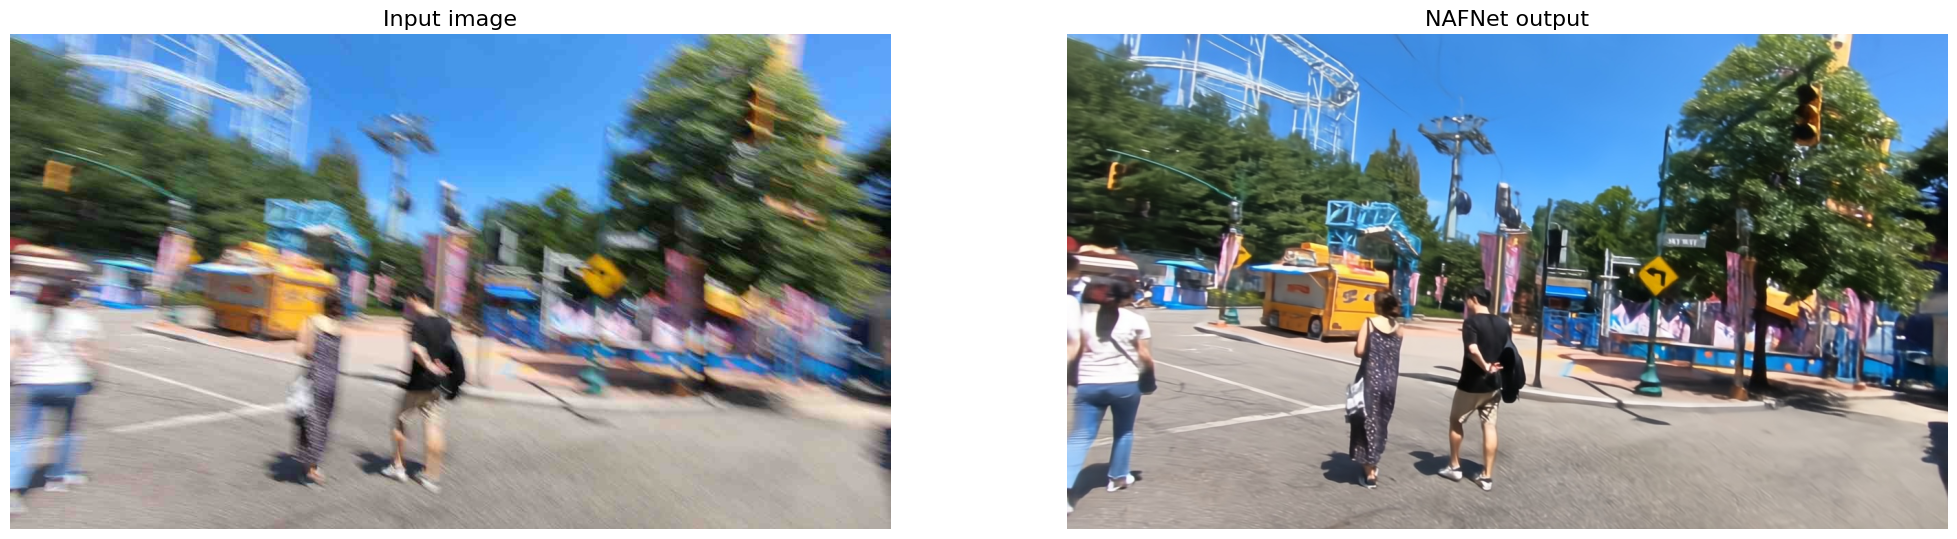

In [7]:
input_path = 'demo_input/blurry-reds-0.jpg'
output_path = 'demo_output/blurry-reds-0.jpg'

img_input = imread(input_path)
inp = img2tensor(img_input)
single_image_inference(NAFNet, inp, output_path)
img_output = imread(output_path)
display(img_input, img_output)

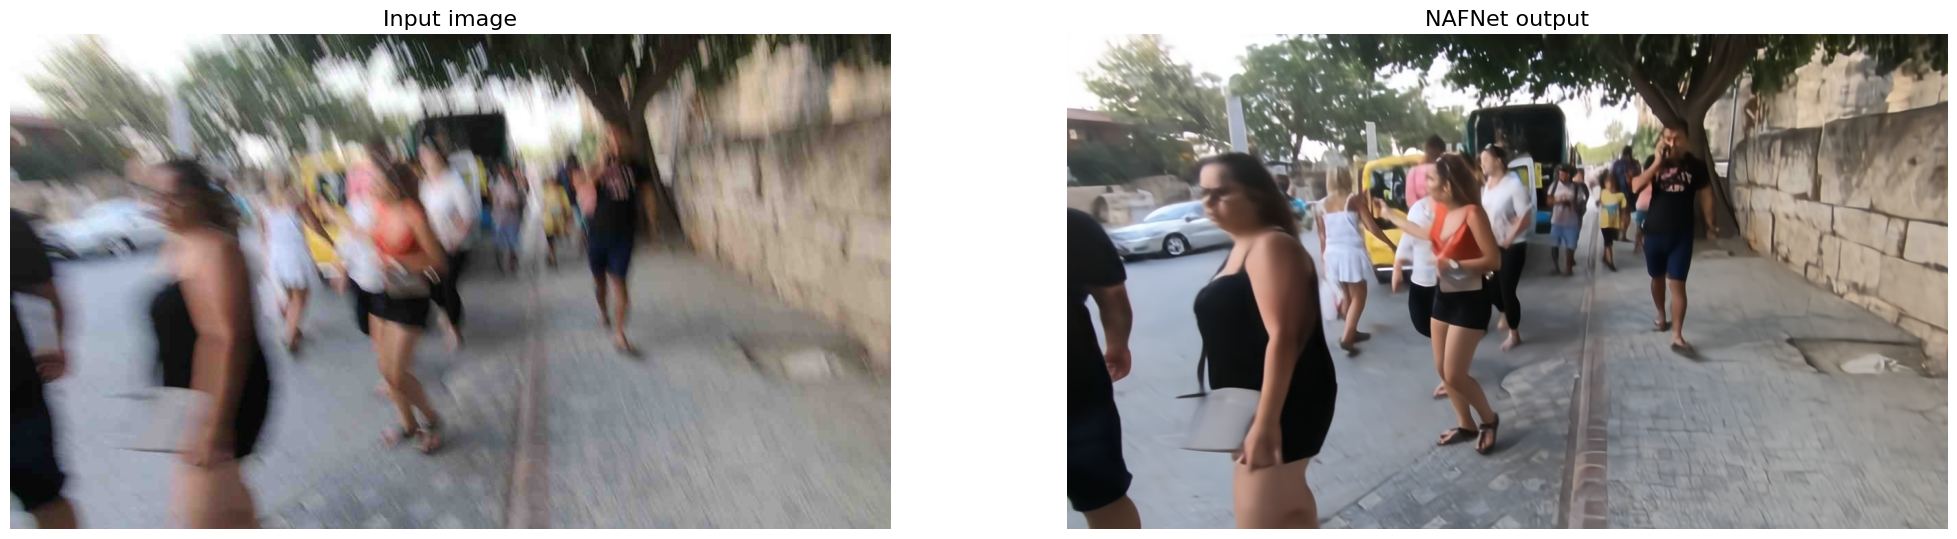

In [ ]:
input_path = 'demo_input/blurry-reds-1.jpg'
output_path = 'demo_output/blurry-reds-1.jpg'

img_input = imread(input_path)
inp = img2tensor(img_input)
single_image_inference(NAFNet, inp, output_path)
img_output = imread(output_path)
display(img_input, img_output)

# Try it on uploaded images

## 1. Upload images

In [10]:
import os
from google.colab import files
import shutil

upload_folder = 'upload/input'
result_folder = 'upload/output'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.makedirs(upload_folder)
os.makedirs(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving output_0004.png to output_0004.png
Saving output_0005.png to output_0005.png
Saving output_0031.png to output_0031.png
Saving output_0032.png to output_0032.png
Saving output_0043.png to output_0043.png
Saving output_0044.png to output_0044.png
Saving output_0045.png to output_0045.png
Saving output_0046.png to output_0046.png
move output_0004.png to upload/input/output_0004.png
move output_0005.png to upload/input/output_0005.png
move output_0031.png to upload/input/output_0031.png
move output_0032.png to upload/input/output_0032.png
move output_0043.png to upload/input/output_0043.png
move output_0044.png to upload/input/output_0044.png
move output_0045.png to upload/input/output_0045.png
move output_0046.png to upload/input/output_0046.png


## Inference

In [11]:
import glob
input_list = sorted(glob.glob(os.path.join(upload_folder, '*')))
for input_path in input_list:
  img_input = imread(input_path)
  inp = img2tensor(img_input)
  output_path = os.path.join(result_folder, os.path.basename(input_path))
  single_image_inference(NAFNet, inp, output_path)

## 3. Visualize (Optional)

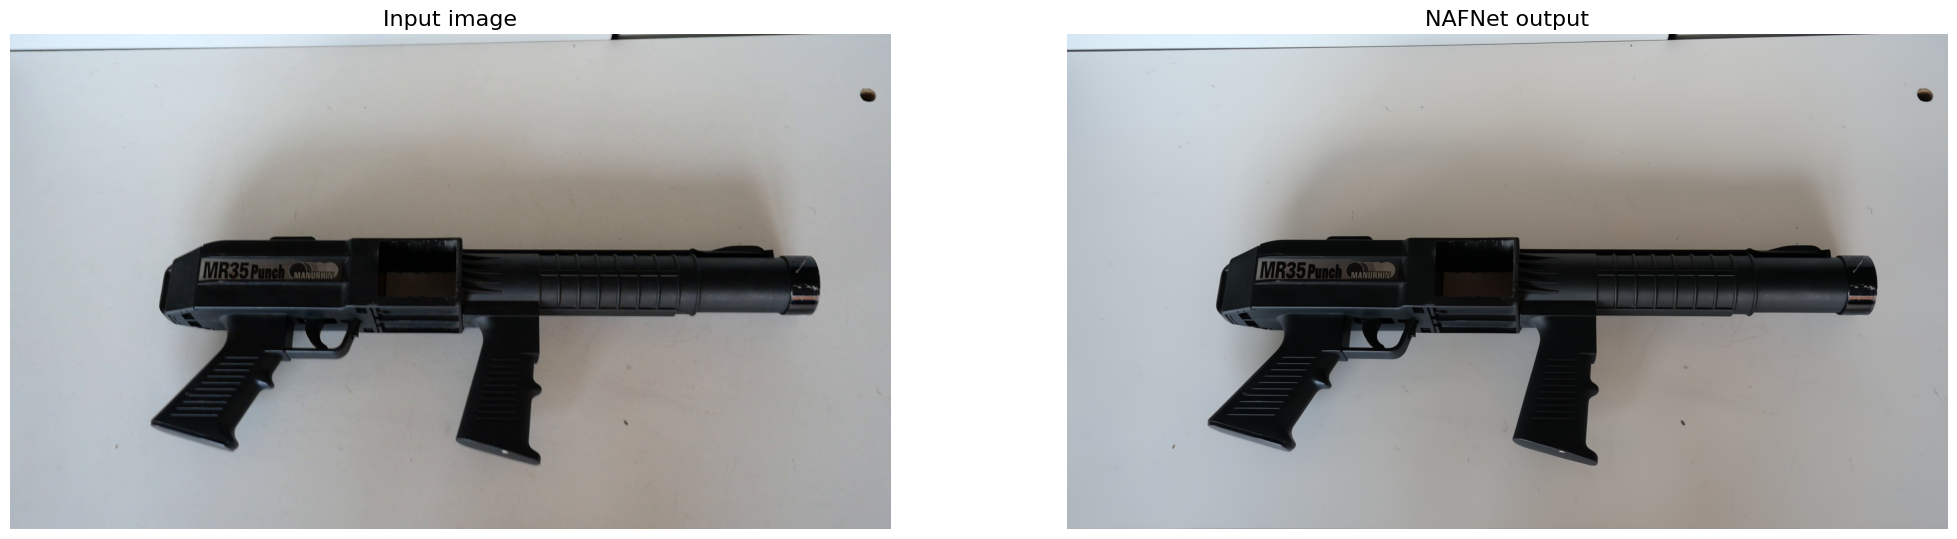

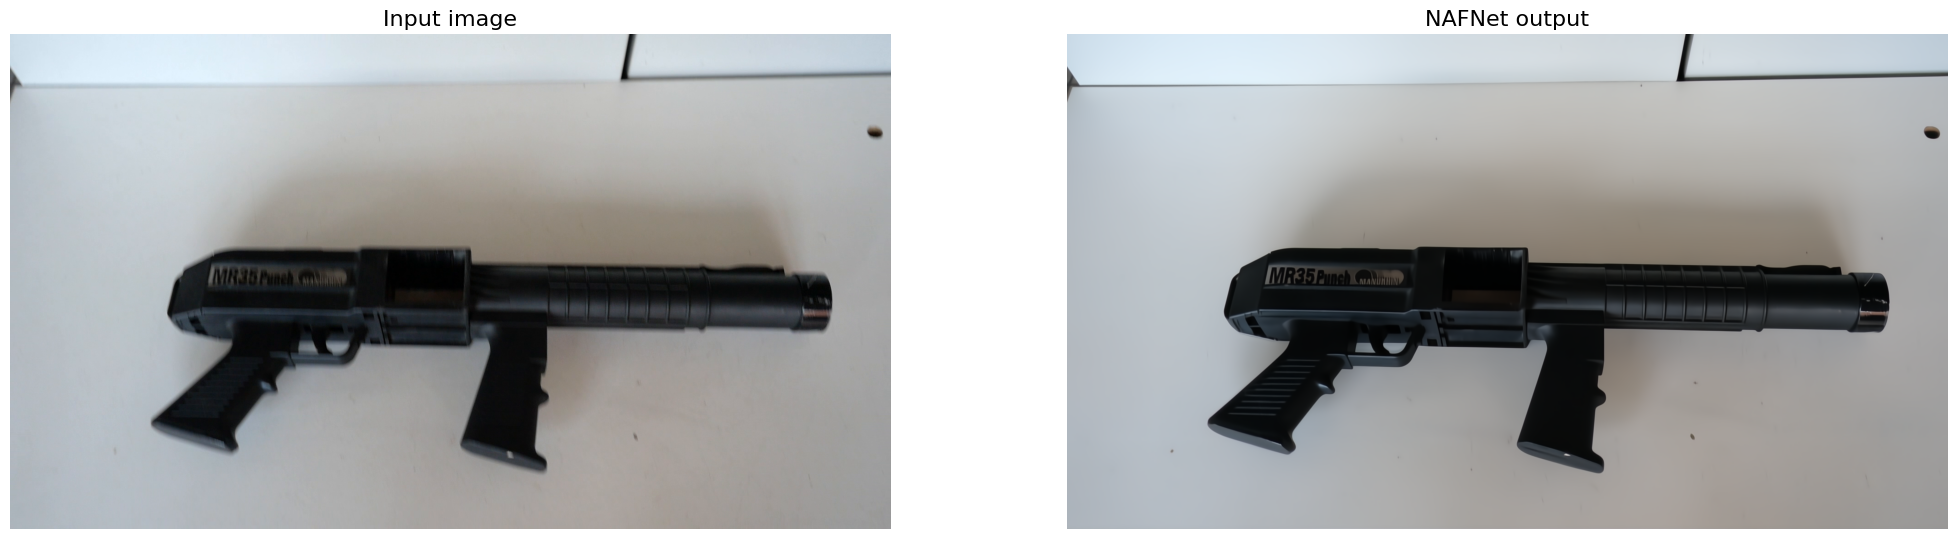

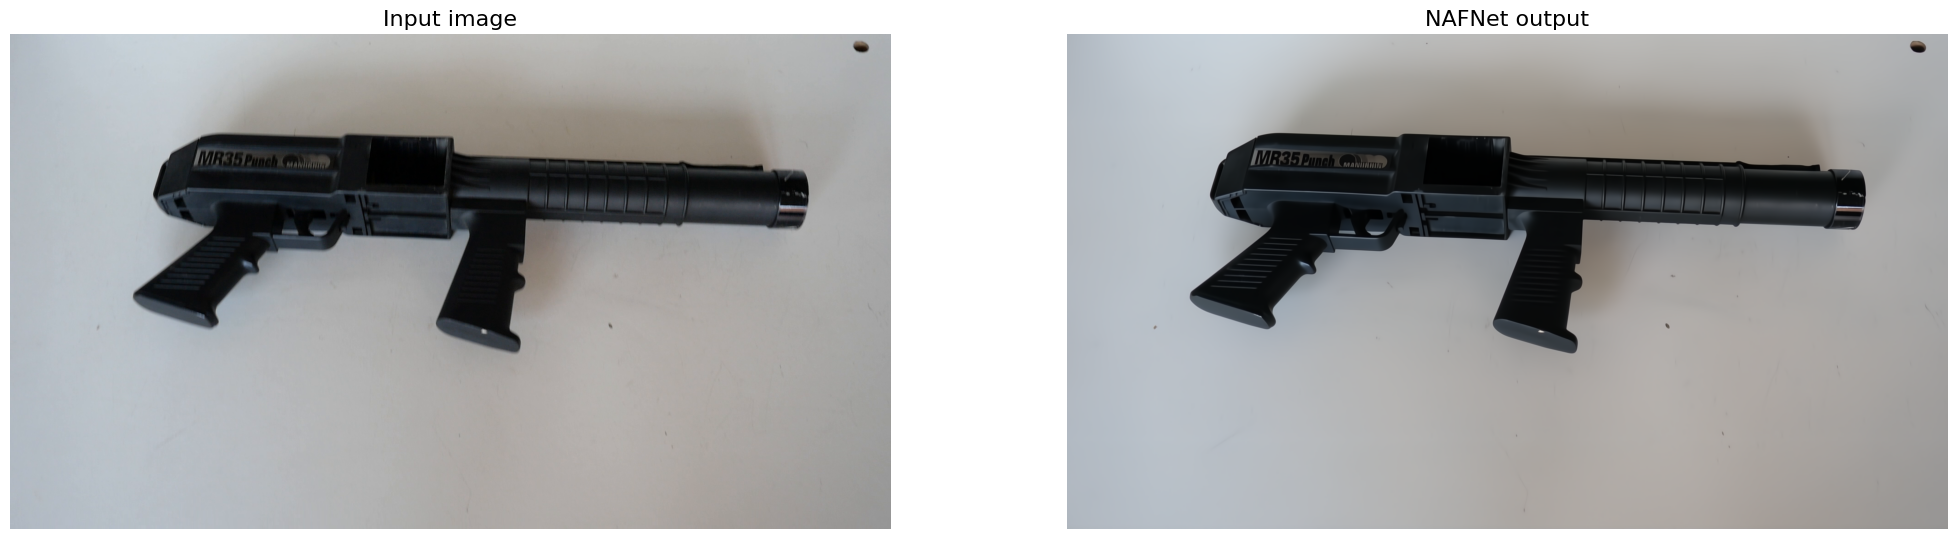

In [10]:
# visualize
input_list = sorted(glob.glob(os.path.join(upload_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)

## 4. Download results

In [12]:
# download the result
print(f'Download {result_folder}')
os.system(f'zip -r -j download.zip {result_folder}/*')
files.download("download.zip")

Download upload/output


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>